In [1407]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec

Parámetros del sistema

In [1720]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 10 # Frecuencia natural x<0
m = 1 # masa del oscilador
N = 100 # Numero de fonones
X_0 = 10 # Condición inicial

Frecuencia natural del oscilador

In [1721]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [1722]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [1723]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [1724]:
x = np.linspace(-25,25,1500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


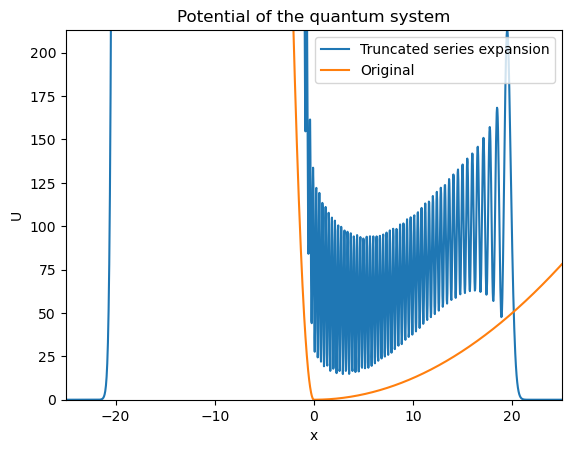

In [1725]:
fig1 = plt.figure()
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

Simulación de la dinámica cuántica

In [1726]:
dt = 0.05 # Paso de tiempo
tf = 500 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [1727]:
lines = ['dt = '+str(dt),'tf = '+str(tf),'w_0 = '+str(w_0),'W_0 = '+str(W_0),'N = '+str(N),'X_0 = '+str(X_0)]
with open('param.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [1728]:
def check_state(psi):
    check = np.sum(np.diagonal(ket2dm(psi).full())[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [1729]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5)*math.sqrt(w_0*m))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

In [1730]:
H = w_0*momentum(N)**2/2+U_q
options = Options(store_states=True,nsteps=100000)
result = mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)
# result2 = mesolve(H, psi02, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)

Overlap integrals and "coherence"

In [1731]:
O = []
coh = []
O2 = []

for i in tqdm(range(np.size(tvec))): 
    psi = result.states[i]
    #check_state(psi)
    alpha = expect(destroy(N),psi)
    
    psi_t = coherent(N,alpha)
    O.append(psi.overlap(psi0))
    coh.append(psi_t.overlap(psi))

    # psi2 = result2.states[i]
    # O2.append(psi2.overlap(psi02))

100%|██████████| 10001/10001 [01:06<00:00, 151.52it/s]


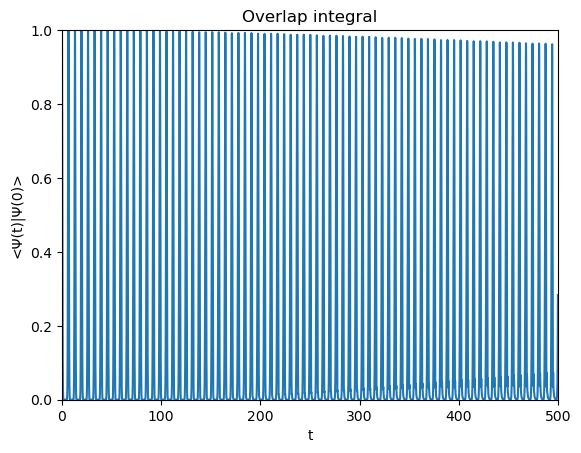

In [1732]:
fig2 = plt.figure()
plt.plot(tvec,np.abs(O))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Overlap integral')
plt.xlabel('t')
plt.ylabel('<Ψ(t)|Ψ(0)>')
plt.show()

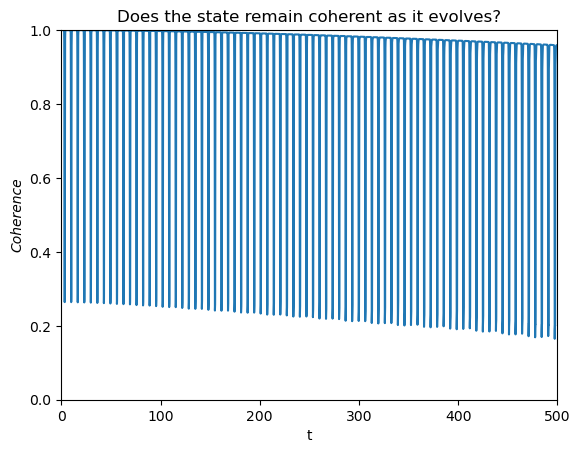

In [1733]:
fig3 = plt.figure()
plt.plot(tvec,np.abs(coh))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Does the state remain coherent as it evolves?')
plt.xlabel('t')
plt.ylabel('Coherence', style = 'italic')
plt.show()

In [1734]:
fou = scipy.fft.fft(np.abs(O))
n = np.size(np.abs(O))
freq = np.fft.fftfreq(n,dt)[:n//2]

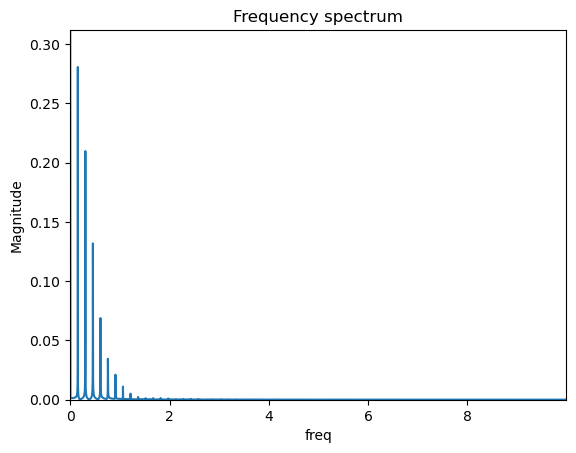

In [1735]:
fig4 = plt.figure()
plt.plot(freq,(2/n)*np.abs(fou[:n//2]))
plt.xlim([np.min(freq),np.max(freq)])
plt.ylim([0,max((2/n)*fou)])
plt.title('Frequency spectrum')
plt.xlabel('freq')
plt.ylabel('Magnitude')
plt.show()

Evolución de la varianza

In [1736]:
desv_x = np.sqrt(result.expect[2]-result.expect[0]*result.expect[0])
desv_p = np.sqrt(result.expect[3]-result.expect[1]*result.expect[1])

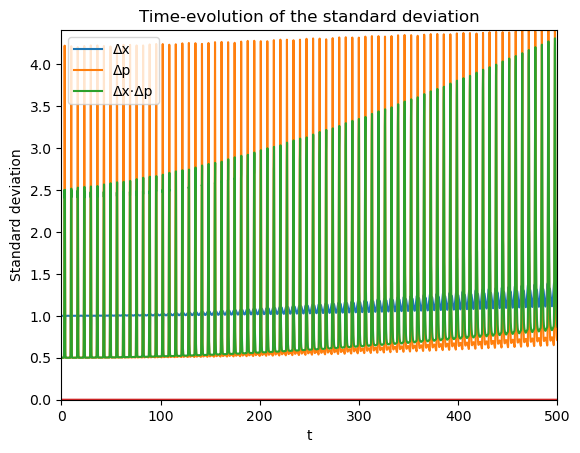

In [1740]:
fig5 = plt.figure()
plt.plot(tvec,desv_x, label = 'Δx')
plt.plot(tvec,desv_p, label = 'Δp')
plt.plot(tvec,desv_x*desv_p, label = 'Δx·Δp')
plt.ylim([0,np.max([desv_p,desv_x*desv_p,desv_x])])
plt.xlim([0,tf])
plt.title('Time-evolution of the standard deviation')
plt.xlabel('t')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

Comparación con caso clásico

In [1741]:
def EDO(t,y):
    x,v = y
    return [v,-W(x)**2*x]

In [1742]:
sol = scipy.integrate.solve_ivp(EDO, [0,tf], [x_0,p_0], method = 'Radau',t_eval = tvec)
xc,vc = sol.y
pc = m*vc

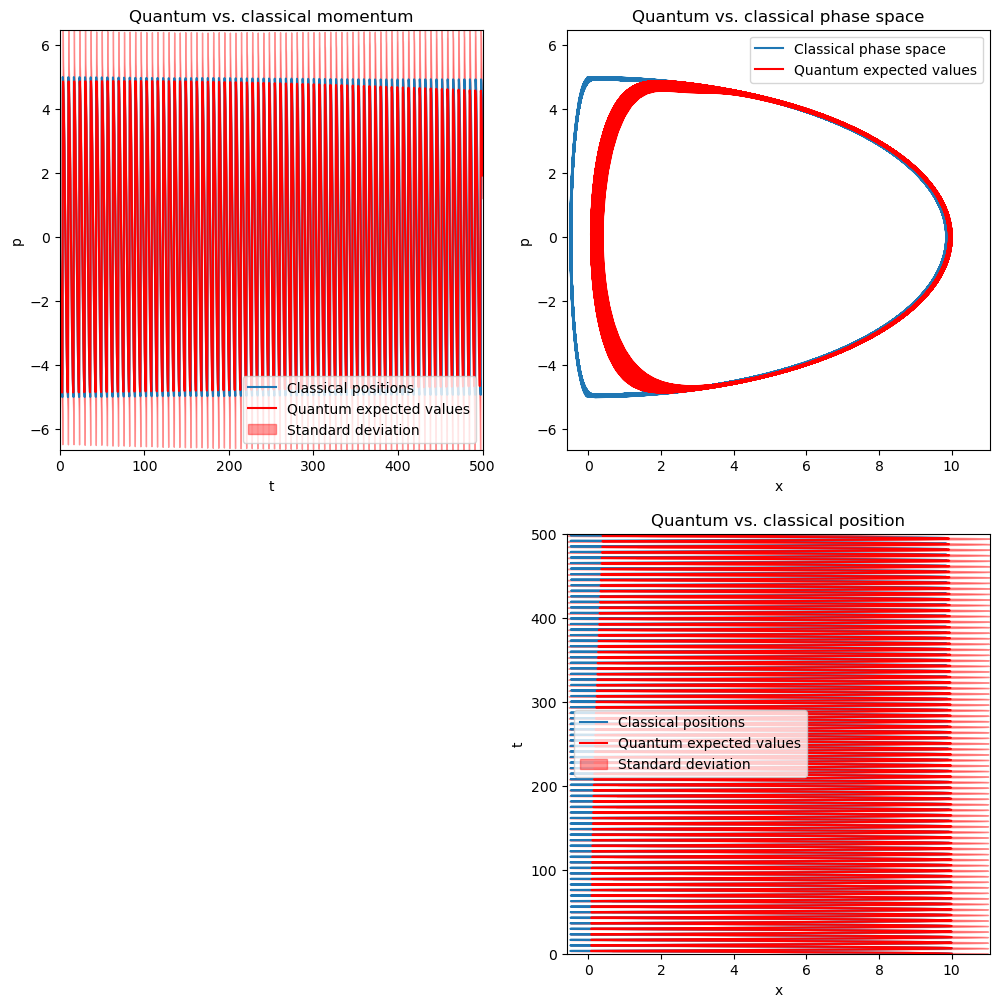

In [1743]:
fig6 = plt.figure(figsize=(12,12), constrained_layout=True)

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax3 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])
ax2 = plt.subplot(gs[1, 2:])

ax1.plot(xc,pc,label='Classical phase space')
ax1.plot(result.expect[0],result.expect[1],label='Quantum expected values',color = 'red')
ax1.set_ylim([np.min([result.expect[1]-desv_p,pc]),np.max([result.expect[1]+desv_p,pc])])
ax1.set_xlim([np.min([result.expect[0]-desv_x,xc]),np.max([result.expect[0]+desv_x,xc])])
ax1.set_title('Quantum vs. classical phase space')
ax1.set_xlabel('x')
ax1.set_ylabel('p')
ax1.legend()

ax2.plot(xc,tvec,label='Classical positions')
ax2.plot(result.expect[0],tvec,label='Quantum expected values', color = 'red')
ax2.fill_betweenx(tvec,result.expect[0]-desv_x,result.expect[0]+desv_x,alpha = 0.4, color = 'red', label = 'Standard deviation')
ax2.set_xlim([np.min([result.expect[0]-desv_x,xc]),np.max([result.expect[0]+desv_x,xc])])
ax2.set_ylim([0,tf])
ax2.set_title('Quantum vs. classical position')
ax2.set_ylabel('t')
ax2.set_xlabel('x')
ax2.legend()

ax3.plot(tvec,pc,label='Classical momentums')
ax3.plot(tvec,result.expect[1],label='Quantum expected values', color = 'red')
ax3.fill_between(tvec,result.expect[1]-desv_p,result.expect[1]+desv_p,alpha = 0.4, color = 'red', label = 'Standard deviation')
ax3.set_ylim([np.min([result.expect[1]-desv_p,pc]),np.max([result.expect[1]+desv_p,pc])])
ax3.set_xlim([0,tf])
ax3.set_title('Quantum vs. classical momentum')
ax3.set_xlabel('t')
ax3.set_ylabel('p')
ax3.legend()

Save data and figures

In [1747]:
fig1.savefig('Quantum_potential.png')

In [1748]:
fig2.savefig('Overlap.png')

In [1749]:
fig3.savefig('Coherence.png')

In [1750]:
fig4.savefig('Frequency spectrum.png')

In [1751]:
fig5.savefig('Standard deviation.png')

In [1752]:
fig6.savefig('Classical_vs_quantum.png')

C:\Users\rodri\AppData\Local\Temp\ipykernel_18028\907192929.py:1: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig6.savefig('Classical_vs_quantum.png')
